In [1]:
from __future__ import print_function
import sys
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

import ROOT
%jsroot on
# from ROOT import TCanvas, TH1F, TH2F, TF1, TMath, TGraph, TFile, TSpectrum, TPaveText, TMultiGraph, TGraphErrors, TLine
from ROOT import gStyle, gROOT, gDirectory, gPad

import constants
import crv_event
import crv_spill
import utils
import geometry
import geometry_constants
import filepath

gROOT.Reset()
gROOT.SetBatch(1)
gROOT.ProcessLine( "gErrorIgnoreLevel = 1001;")
gStyle.SetOptStat(111110)
gStyle.SetOptFit(0)
gStyle.SetLineScalePS(0.3)

tgeometry = geometry.testBenchGeometry(geometry_constants.setup_dict['crvaging-007'][0])

offsetFileList = filepath.getfilelist(["1370"])[0]
refFileList = filepath.getfilelist(["1354"])[0]

Welcome to JupyROOT 6.28/00


In [2]:
# check PE sum, see where to cut for "shower"

pdfpages = PdfPages("timingAlignmentFEB_exampleShower.pdf")

fFile = ROOT.TFile(refFileList[0], "READ")
fTree = fFile.Get("run")

hist_sum_tot = ROOT.TH1F("hist_sum_tot", "Total light yield per event; n_{PE}; count", 500, 0., 10000.)
hist_sum_feb = [None]*6
hist_sum_tot_goodfit = ROOT.TH1F("hist_sum_tot_goodfit", "Total light yield per event; n_{PE}; count", 500, 0., 10000.)
hist_sum_feb_goodfit = [None]*6
for i in range(6):
    hist_sum_feb[i] = ROOT.TH1F("hist_sum_feb_%i"%i, "Light yield sum per FEB; n_{PE}; count", 500, 0., 2000.)
    hist_sum_feb_goodfit[i] = ROOT.TH1F("hist_sum_feb_%i_goodfit"%i, "Light yield sum per FEB; n_{PE}; count", 500, 0., 2000.)

nplot = 0
nEntries = fTree.GetEntries()
for iEntry in range(nEntries):
    if iEntry % 10000 == 0:
        print("processed %i/%i entries..."%(iEntry, nEntries))
    tEvent = crv_event.crv_event(fTree, iEntry, 0b1010, 6)
    tFEBsum = np.sum(tEvent.PEsTemperatureCorrected, axis=1)
    tTOTsum = np.sum(tFEBsum)
    tFEBsum_goodfit = np.array([np.sum(tEvent.PEsTemperatureCorrected[i][tEvent.fitStatus[i]==1]) for i in range(6)])
    tTOTsum_goodfit = np.sum(tFEBsum_goodfit)
    hist_sum_tot.Fill(tTOTsum)
    hist_sum_tot_goodfit.Fill(tTOTsum_goodfit)
    for i in range(6):
        hist_sum_feb[i].Fill(tFEBsum[i])
        hist_sum_feb_goodfit[i].Fill(tFEBsum_goodfit[i])
    # if tTOTsum_goodfit > 3000 and nplot < 20:
    if np.all(tFEBsum>300) and nplot < 20:
        tEvent.plotEvent(pdfpages, [tgeometry], True)
        nplot += 1

pdfpages.close()
from IPython.display import IFrame
IFrame("timingAlignmentFEB_exampleShower.pdf", width=800, height=600)

processed 0/175728 entries...
processed 10000/175728 entries...
processed 20000/175728 entries...
processed 30000/175728 entries...
processed 40000/175728 entries...
processed 50000/175728 entries...
processed 60000/175728 entries...
processed 70000/175728 entries...
processed 80000/175728 entries...
processed 90000/175728 entries...
processed 100000/175728 entries...
processed 110000/175728 entries...
processed 120000/175728 entries...
processed 130000/175728 entries...
processed 140000/175728 entries...
processed 150000/175728 entries...
processed 160000/175728 entries...
processed 170000/175728 entries...


In [3]:
c1 = ROOT.TCanvas("c1", "c1", 900, 400)
c1.SetLogy()
hist_sum_tot.Draw()
c1.Draw()

In [4]:
hist_sum_tot_goodfit.Draw()
c1.Draw()

In [5]:
c2 = ROOT.TCanvas("c2", "c2", 900, 400)
gStyle.SetOptStat(0)
c2.SetLogy()
fLegend = ROOT.TLegend(0.75, 0.6, 0.9, 0.9)
for i in range(6):
    hist_sum_feb[i].SetLineColor(constants.rootcolors[i])
    hist_sum_feb[i].Draw("SAME" if i > 0 else "")
    fLegend.AddEntry(hist_sum_feb[i], "FEB%i"%i)
fLegend.Draw("SAME")
c2.Draw()

In [6]:
fLegend = ROOT.TLegend(0.75, 0.6, 0.9, 0.9)
for i in range(6):
    hist_sum_feb_goodfit[i].SetLineColor(constants.rootcolors[i])
    hist_sum_feb_goodfit[i].Draw("SAME" if i > 0 else "")
    fLegend.AddEntry(hist_sum_feb_goodfit[i], "FEB%i"%i)
fLegend.Draw("SAME")
c2.Draw()

In [7]:
fFile.Close()

In [8]:
gROOT.Reset()
gStyle.SetOptStat(0)
gStyle.SetOptFit(0)
gStyle.SetLineScalePS(0.3)

tmin = 900.
tmax = 1100.
nbin = 200
showerthres = 1800
singleFEBshowerthres = 300

def plotTimeMean(filelist, tag):
    hist_tmean = [None]*6
    hist_tmeanwtd = [None]*6
    hist_tmeanthresh = [None]*6
    hist_tmeanthreshwtd = [None]*6
    for i in range(6):
        hist_tmean[i] = ROOT.TH1F("hist_tmean_%s_feb%i"%(tag,i), "Average Hit Time (%s); t_{avg} [ns]; count"%tag, nbin, tmin, tmax)
        hist_tmeanwtd[i] = ROOT.TH1F("hist_tmeanwtd_%s_feb%i"%(tag,i), "Weighted Average Hit Time (%s); t_{avg} [ns]; count"%tag, nbin, tmin, tmax)
        hist_tmeanthresh[i] = ROOT.TH1F("hist_tmeanthresh_%s_feb%i"%(tag,i), "Average Hit Time over 6PE Threshold (%s); t_{avg} [ns]; count"%tag, nbin, tmin, tmax)
        hist_tmeanthreshwtd[i] = ROOT.TH1F("hist_tmeanthreshwtd_%s_feb%i"%(tag,i), "Weighted Average Hit Time over 6PE Threshold (%s); t_{avg} [ns]; count"%tag, nbin, tmin, tmax)
        
    for filename in filelist:
        print("Processing file %s"%(filename.split('/')[-1]))
        fFile = ROOT.TFile(filename, "READ")
        fTree = fFile.Get("run")
        nEntries = fTree.GetEntries()
        for iEntry in range(nEntries):
            if iEntry % 10000 == 0:            
                print("processed %i/%i entries..."%(iEntry, nEntries))            
            tEvent = crv_event.crv_event(fTree, iEntry, 0b1010, 6)
            tgoodhitPE = [tEvent.PEsTemperatureCorrected[i][tEvent.fitStatus[i]==1] for i in range(6)]
            tTOTsum_goodfit = sum([np.sum(tgoodhitPE[i]) for i in range(6)])
            # if tTOTsum_goodfit>showerthres:
            if np.all(np.array([np.sum(tgoodhitPE[i]) for i in range(6)])>singleFEBshowerthres):
                tgoodhittime = [tEvent.time[i][tEvent.fitStatus[i]==1] for i in range(6)]
                t_tmean = [np.mean(tgoodhittime[i]) if np.any(tgoodhittime[i]) else None for i in range(6)]
                t_tmeanwtd = [np.sum(tgoodhitPE[i]*tgoodhittime[i])/np.sum(tgoodhitPE[i]) if np.any(tgoodhittime[i]) else None for i in range(6)]

                tgoodhitPE_overthresh = [tgoodhitPE[i][tgoodhitPE[i]>6.] for i in range(6)]
                tgoodhittime_overthresh = [tgoodhittime[i][tgoodhitPE[i]>6.] for i in range(6)]
                t_tmeanthresh = [np.mean(tgoodhittime_overthresh[i]) if np.any(tgoodhittime_overthresh[i]) else None for i in range(6)]
                t_tmeanthreshwtd = [np.sum(tgoodhitPE_overthresh[i]*tgoodhittime_overthresh[i])/np.sum(tgoodhitPE_overthresh[i]) if np.any(tgoodhittime_overthresh[i]) else None for i in range(6)]

                for i in range(6):
                    if t_tmean[i]:
                        hist_tmean[i].Fill(t_tmean[i])
                    if t_tmeanwtd[i]:
                        hist_tmeanwtd[i].Fill(t_tmeanwtd[i])
                    if t_tmeanthresh[i]:
                        hist_tmeanthresh[i].Fill(t_tmeanthresh[i])
                    if t_tmeanthreshwtd[i]:
                        hist_tmeanthreshwtd[i].Fill(t_tmeanthreshwtd[i])

        fFile.Close()
    
    func = [[None]*6 for i in range(4)]
    
    # c01 = ROOT.TCanvas("c01", "c01", 900, 400)
    print("----- Plain Mean Time -----")
    fLegend1 = ROOT.TLegend(0.8, 0.6, 0.9, 0.9)
    fStack1 = ROOT.THStack("stack_tmean_%s"%(tag), "Average Hit Time (%s); t_{avg} [ns]; count"%tag)
    fitmean = []
    fitmean_err = []
    fitrms = []
    fitrms_err = []
    for i in range(6):
        func[0][i] = ROOT.TF1("func_%s_tmean_FEB%i"%(tag, i), "[0]*TMath::Gaus(x,[1],[2])",tmin,tmax)
        func[0][i].SetParameter(0,hist_tmean[i].GetEntries()/2.5/hist_tmean[i].GetRMS())
        func[0][i].SetParameter(1,hist_tmean[i].GetMean())
        func[0][i].SetParameter(2,hist_tmean[i].GetRMS()/2.)
        func[0][i].SetParName(0, "A")
        func[0][i].SetParName(1, "#mu")
        func[0][i].SetParName(2, "#sigma")
        func[0][i].SetParLimits(1, hist_tmean[i].GetMean()-2.*hist_tmean[i].GetRMS(), hist_tmean[i].GetMean()+2.*hist_tmean[i].GetRMS())
        func[0][i].SetParLimits(2, .005, 200)
        fitoption = "QRS"
        if hist_tmean[i].GetEntries() < 2000:
            fitoption+="L"
        fitmin = hist_tmean[i].GetMean()-2.*hist_tmean[i].GetRMS()
        fitmax = hist_tmean[i].GetMean()+2.*hist_tmean[i].GetRMS()
        frp = hist_tmean[i].Fit(func[0][i],fitoption,"",fitmin,fitmax)      
        fitmean.append(func[0][i].GetParameter(1))
        fitmean_err.append(func[0][i].GetParError(1))
        fitrms.append(func[0][i].GetParameter(2))
        fitrms_err.append(func[0][i].GetParError(2))
              
        hist_tmean[i].SetLineColor(constants.rootcolors[i])
        fStack1.Add(hist_tmean[i])
        func[0][i].SetLineColor(constants.rootcolors[i])
        
        fLegend1.AddEntry(hist_tmean[i], "FEB%i"%i)
    # fStack1.Draw("NOSTACK")
    # for i in range(6):
        # func[0][i].DrawClone("SAME")
    # fLegend1.Draw("SAME")
    print("fit mean", fitmean)
    print("     +/-", fitmean_err)
    print("fit  rms", fitrms)
    print("     +/-", fitrms_err)
    
    # c02 = ROOT.TCanvas("c02", "c02", 900, 400)
    print("----- Weighted Time -----")
    fLegend2 = ROOT.TLegend(0.8, 0.6, 0.9, 0.9)
    fStack2 = ROOT.THStack("stack_tmeanwtd_%s"%(tag), "Weighted Average Hit Time (%s); t_{avg} [ns]; count"%tag)
    fitmean = []
    fitmean_err = []
    fitrms = []
    fitrms_err = []
    for i in range(6):
        func[1][i] = ROOT.TF1("func_%s_tmeanwtd_FEB%i"%(tag, i), "[0]*TMath::Gaus(x,[1],[2])",tmin,tmax)
        func[1][i].SetParameter(0,hist_tmeanwtd[i].GetEntries()/2.5/hist_tmean[i].GetRMS())
        func[1][i].SetParameter(1,hist_tmeanwtd[i].GetMean())
        func[1][i].SetParameter(2,hist_tmeanwtd[i].GetRMS()/2.)
        func[1][i].SetParName(0, "A")
        func[1][i].SetParName(1, "#mu")
        func[1][i].SetParName(2, "#sigma")
        func[1][i].SetParLimits(1, hist_tmeanwtd[i].GetMean()-2.*hist_tmeanwtd[i].GetRMS(), hist_tmeanwtd[i].GetMean()+2.*hist_tmeanwtd[i].GetRMS())
        func[1][i].SetParLimits(2, .005, 200)
        fitoption = "QRS"
        if hist_tmeanwtd[i].GetEntries() < 2000:
            fitoption+="L"
        fitmin = hist_tmeanwtd[i].GetMean()-2.*hist_tmeanwtd[i].GetRMS()
        fitmax = hist_tmeanwtd[i].GetMean()+2.*hist_tmeanwtd[i].GetRMS()
        frp = hist_tmeanwtd[i].Fit(func[1][i],fitoption,"",fitmin,fitmax)      
        fitmean.append(func[1][i].GetParameter(1))
        fitmean_err.append(func[1][i].GetParError(1))
        fitrms.append(func[1][i].GetParameter(2))
        fitrms_err.append(func[1][i].GetParError(2))
              
        hist_tmeanwtd[i].SetLineColor(constants.rootcolors[i])
        fStack2.Add(hist_tmeanwtd[i])
        func[1][i].SetLineColor(constants.rootcolors[i])
        
        fLegend2.AddEntry(hist_tmeanwtd[i], "FEB%i"%i)
    # fStack2.Draw("NOSTACK")
    # for i in range(6):
        # func[1][i].DrawClone("SAME")
    # fLegend2.Draw("SAME")
    print("fit mean", fitmean)
    print("     +/-", fitmean_err)
    print("fit  rms", fitrms)
    print("     +/-", fitrms_err)
          
    # c03 = ROOT.TCanvas("c03", "c03", 900, 400)
    print("----- Mean Time Over Threshold -----")
    fLegend3 = ROOT.TLegend(0.8, 0.6, 0.9, 0.9)
    fStack3 = ROOT.THStack("stack_tmeanthresh_%s"%(tag), "Average Hit Time over 6PE Threshold (%s); t_{avg} [ns]; count"%tag)
    fitmean = []
    fitmean_err = []
    fitrms = []
    fitrms_err = []
    for i in range(6):
        func[2][i] = ROOT.TF1("func_%s_tmeanthresh_FEB%i"%(tag, i), "[0]*TMath::Gaus(x,[1],[2])",tmin,tmax)
        func[2][i].SetParameter(0,hist_tmeanthresh[i].GetEntries()/2.5/hist_tmean[i].GetRMS())
        func[2][i].SetParameter(1,hist_tmeanthresh[i].GetMean())
        func[2][i].SetParameter(2,hist_tmeanthresh[i].GetRMS()/2.)
        func[2][i].SetParName(0, "A")
        func[2][i].SetParName(1, "#mu")
        func[2][i].SetParName(2, "#sigma")
        func[2][i].SetParLimits(1, hist_tmeanthresh[i].GetMean()-2.*hist_tmeanthresh[i].GetRMS(), hist_tmeanthresh[i].GetMean()+2.*hist_tmeanthresh[i].GetRMS())
        func[2][i].SetParLimits(2, .005, 200)
        fitoption = "QRS"
        if hist_tmeanthresh[i].GetEntries() < 2000:
            fitoption+="L"
        fitmin = hist_tmeanthresh[i].GetMean()-2.*hist_tmeanthresh[i].GetRMS()
        fitmax = hist_tmeanthresh[i].GetMean()+2.*hist_tmeanthresh[i].GetRMS()
        frp = hist_tmeanthresh[i].Fit(func[2][i],fitoption,"",fitmin,fitmax)      
        fitmean.append(func[2][i].GetParameter(1))
        fitmean_err.append(func[2][i].GetParError(1))
        fitrms.append(func[2][i].GetParameter(2))
        fitrms_err.append(func[2][i].GetParError(2))
              
        hist_tmeanthresh[i].SetLineColor(constants.rootcolors[i])
        fStack3.Add(hist_tmeanthresh[i])
        func[2][i].SetLineColor(constants.rootcolors[i])
        
        fLegend3.AddEntry(hist_tmeanthresh[i], "FEB%i"%i)
    # fStack3.Draw("NOSTACK")
    # for i in range(6):
        # func[2][i].DrawClone("SAME")
    # fLegend3.Draw("SAME")
    print("fit mean", fitmean)
    print("     +/-", fitmean_err)
    print("fit  rms", fitrms)
    print("     +/-", fitrms_err)
              
    # c04 = ROOT.TCanvas("c04", "c04", 900, 400)
    print("----- Weighted Time Over Threshold-----")
    fLegend4 = ROOT.TLegend(0.8, 0.6, 0.9, 0.9)
    fStack4 = ROOT.THStack("stack_tmeanthreshwtd_%s"%(tag), "Weighted Average Hit Time over 6PE Threshold (%s); t_{avg} [ns]; count"%tag)
    fitmean = []
    fitmean_err = []
    fitrms = []
    fitrms_err = []
    for i in range(6):
        func[3][i] = ROOT.TF1("func_%s_tmeanthreshwtd_FEB%i"%(tag, i), "[0]*TMath::Gaus(x,[1],[2])",tmin,tmax)
        func[3][i].SetParameter(0,hist_tmeanthreshwtd[i].GetEntries()/2.5/hist_tmean[i].GetRMS())
        func[3][i].SetParameter(1,hist_tmeanthreshwtd[i].GetMean())
        func[3][i].SetParameter(2,hist_tmeanthreshwtd[i].GetRMS()/2.)
        func[3][i].SetParName(0, "A")
        func[3][i].SetParName(1, "#mu")
        func[3][i].SetParName(2, "#sigma")
        func[3][i].SetParLimits(1, hist_tmeanthreshwtd[i].GetMean()-2.*hist_tmeanthreshwtd[i].GetRMS(), hist_tmeanthreshwtd[i].GetMean()+2.*hist_tmeanthreshwtd[i].GetRMS())
        func[3][i].SetParLimits(2, .005, 200)
        fitoption = "QRS"
        if hist_tmeanthreshwtd[i].GetEntries() < 2000:
            fitoption+="L"
        fitmin = hist_tmeanthreshwtd[i].GetMean()-2.*hist_tmeanthreshwtd[i].GetRMS()
        fitmax = hist_tmeanthreshwtd[i].GetMean()+2.*hist_tmeanthreshwtd[i].GetRMS()
        frp = hist_tmeanthreshwtd[i].Fit(func[3][i],fitoption,"",fitmin,fitmax)      
        fitmean.append(func[3][i].GetParameter(1))
        fitmean_err.append(func[3][i].GetParError(1))
        fitrms.append(func[3][i].GetParameter(2))
        fitrms_err.append(func[3][i].GetParError(2))
              
        hist_tmeanthreshwtd[i].SetLineColor(constants.rootcolors[i])
        fStack4.Add(hist_tmeanthreshwtd[i])
        func[3][i].SetLineColor(constants.rootcolors[i])
        
        fLegend4.AddEntry(hist_tmeanthreshwtd[i], "FEB%i"%i)
    # fStack4.Draw("NOSTACK")
    # for i in range(6):
        # func[3][i].DrawClone("SAME")
    # fLegend4.Draw("SAME")
    print("fit mean", fitmean)
    print("     +/-", fitmean_err)
    print("fit  rms", fitrms)
    print("     +/-", fitrms_err)
    
    return [fStack1, fStack2, fStack3, fStack4], func, [fLegend1, fLegend2, fLegend3, fLegend4]

In [9]:
stacks_offset, func_offset, legend_offset = plotTimeMean(offsetFileList, "offset")

Processing file rec.mu2e.CRV_wideband_cosmics.CRVWB-000-001-000.001370_000.root
processed 0/209928 entries...
processed 10000/209928 entries...
processed 20000/209928 entries...
processed 30000/209928 entries...
processed 40000/209928 entries...
processed 50000/209928 entries...
processed 60000/209928 entries...
processed 70000/209928 entries...
processed 80000/209928 entries...
processed 90000/209928 entries...
processed 100000/209928 entries...
processed 110000/209928 entries...
processed 120000/209928 entries...
processed 130000/209928 entries...
processed 140000/209928 entries...
processed 150000/209928 entries...
processed 160000/209928 entries...
processed 170000/209928 entries...
processed 180000/209928 entries...
processed 190000/209928 entries...
processed 200000/209928 entries...
----- Plain Mean Time -----
fit mean [973.6843260305363, 988.2509834608032, 996.84235403754, 1012.0946253839437, 1023.6992147754312, 1035.8294050429536]
     +/- [0.5456014697864475, 0.51685026610306

In [10]:
c01 = ROOT.TCanvas("c01", "c01", 900, 400)
stacks_offset[0].Draw("NOSTACK")
for i in range(6):
    func_offset[0][i].DrawClone("SAME")
legend_offset[0].Draw("SAME")
c01.Draw()

In [11]:
c02 = ROOT.TCanvas("c02", "c02", 900, 400)
stacks_offset[1].Draw("NOSTACK")
for i in range(6):
    func_offset[1][i].DrawClone("SAME")
legend_offset[1].Draw("SAME")
c02.Draw()

In [12]:
c03 = ROOT.TCanvas("c03", "c03", 900, 400)
stacks_offset[2].Draw("NOSTACK")
for i in range(6):
    func_offset[2][i].DrawClone("SAME")
legend_offset[2].Draw("SAME")
c03.Draw()

In [13]:
c04 = ROOT.TCanvas("c04", "c04", 900, 400)
stacks_offset[3].Draw("NOSTACK")
for i in range(6):
    func_offset[3][i].DrawClone("SAME")
legend_offset[3].Draw("SAME")
c04.Draw()

In [14]:
stacks_ref, func_ref, legend_ref = plotTimeMean(refFileList, "reference")

Processing file rec.mu2e.CRV_wideband_cosmics.CRVWB-000-001-000.001354_000.root
processed 0/175728 entries...
processed 10000/175728 entries...
processed 20000/175728 entries...
processed 30000/175728 entries...
processed 40000/175728 entries...
processed 50000/175728 entries...
processed 60000/175728 entries...
processed 70000/175728 entries...
processed 80000/175728 entries...
processed 90000/175728 entries...
processed 100000/175728 entries...
processed 110000/175728 entries...
processed 120000/175728 entries...
processed 130000/175728 entries...
processed 140000/175728 entries...
processed 150000/175728 entries...
processed 160000/175728 entries...
processed 170000/175728 entries...
Processing file rec.mu2e.CRV_wideband_cosmics.CRVWB-000-001-000.001354_001.root
processed 0/180607 entries...
processed 10000/180607 entries...
processed 20000/180607 entries...
processed 30000/180607 entries...
processed 40000/180607 entries...
processed 50000/180607 entries...
processed 60000/180607 e

In [15]:
c05 = ROOT.TCanvas("c05", "c05", 900, 400)
stacks_ref[0].Draw("NOSTACK")
for i in range(6):
    func_ref[0][i].DrawClone("SAME")
legend_ref[0].Draw("SAME")
c05.Draw()

In [16]:
c06 = ROOT.TCanvas("c06", "c06", 900, 400)
stacks_ref[1].Draw("NOSTACK")
for i in range(6):
    func_ref[1][i].DrawClone("SAME")
legend_ref[1].Draw("SAME")
c06.Draw()

In [17]:
c07 = ROOT.TCanvas("c07", "c07", 900, 400)
stacks_ref[2].Draw("NOSTACK")
for i in range(6):
    func_ref[2][i].DrawClone("SAME")
legend_ref[2].Draw("SAME")
c07.Draw()

In [18]:
c08 = ROOT.TCanvas("c08", "c08", 900, 400)
stacks_ref[3].Draw("NOSTACK")
for i in range(6):
    func_ref[3][i].DrawClone("SAME")
legend_ref[3].Draw("SAME")
c08.Draw()

In [72]:
import matplotlib.pyplot as plt
import numpy as np
import geometry, geometry_constants
from functools import reduce
import constants
import scipy.optimize as opt

# ----- Plain Mean Time -----
offset_mean_1 = np.array([973.6843260305363, 988.2509834608032, 996.84235403754, 1012.0946253839437, 1023.6992147754312, 1035.8294050429536])
offset_mean_1_err = np.array([0.5456014697864475, 0.516850266103063, 0.3082449570835024, 0.2644113611792136, 0.22920082234350048, 0.2479656397756571])
offset_rms_1 = np.array([16.045592376269656, 16.588822132109794, 13.921203431650135, 12.862538911374454, 12.917335689608977, 13.562755363548503])
offset_rms_1_err = np.array([0.3774053695049586, 0.39855420483026016, 0.2308242076774718, 0.20534823056781804, 0.1961978722167208, 0.21368047522900824])
ref_mean_1 = np.array([970.3606211122838, 973.4685168508814, 971.8302385021611, 973.5429827028316, 974.4244892158242, 975.5560276097088])
ref_mean_1_err = np.array([0.2886887346901972, 0.3604880624475868, 0.21924727679390799, 0.1929586345147527, 0.18956804531876514, 0.2278035960885063])
ref_rms_1 = np.array([14.346670606720586, 14.976024065463623, 13.042053355016494, 12.581983846879087, 12.53411335127751, 13.326030616807538])
ref_rms_1_err = np.array([0.2048348672390965, 0.2525889984895322, 0.15645318674133968, 0.1394736716653, 0.14326264954557555, 0.15791995276572823])
# ----- Weighted Time -----
offset_mean_2 = np.array([959.4158105809521, 973.5136049555815, 986.2866920056705, 1002.393129310277, 1015.0718090982192, 1027.0268084813838])
offset_mean_2_err = np.array([0.1572244984270128, 0.16534696387230952, 0.17622705675989891, 0.1720332853579407, 0.16493659760328683, 0.1717966171892158])
offset_rms_2 = np.array([9.046549030213356, 9.273644573627745, 9.620802988473988, 9.545177535322123, 9.375064973558894, 9.622927913700899])
offset_rms_2_err = np.array([0.12746167634420758, 0.14438751510851144, 0.16335602005449612, 0.1597913434119853, 0.14587893974429456, 0.15884141463005008])
ref_mean_2 = np.array([958.6787195115992, 960.9626484145826, 961.2039623953953, 963.8276976118206, 965.4325479978643, 964.9637175180153])
ref_mean_2_err = np.array([0.12789889307396152, 0.12590319435531683, 0.12848824189762809, 0.12985434697031906, 0.12398577832431101, 0.1271938502153489])
ref_rms_2 = np.array([9.591098249798184, 9.205964568312433, 9.507209443606248, 9.547429178398867, 9.26605255506672, 9.541372181316916])
ref_rms_2_err = np.array([0.11511084827626128, 0.10529700458661129, 0.11626318520910939, 0.11742269017273266, 0.10593514423466122, 0.11306094872149153])
# ----- Mean Time Over Threshold -----
offset_mean_3 = np.array([959.1289305235439, 973.3258947913038, 985.8952617821163, 1002.2076819625663, 1014.7858607325122, 1026.6939502394089])
offset_mean_3_err = np.array([0.16405778252249092, 0.15282632227581416, 0.1649264068327625, 0.16463378834311015, 0.1710132844095824, 0.17118151907925494])
offset_rms_3 = np.array([9.316932481185576, 9.019823623200994, 9.416446907175773, 9.367230481014737, 9.490354543844262, 9.591899200534543])
offset_rms_3_err = np.array([0.13936420944298167, 0.1198049408845252, 0.14025739786277125, 0.14283977395893288, 0.15828315528618386, 0.15591763350544596])
ref_mean_3 = np.array([958.5562071153737, 960.7111530091157, 961.3411965568773, 963.4812426659886, 965.1130156785695, 964.61961447159])
ref_mean_3_err = np.array([0.12752773939337203, 0.12464541299414122, 0.12114550255915901, 0.12632250900043118, 0.12560866773151247, 0.12379842154257403])
ref_rms_3 = np.array([9.516079165359393, 9.369487962220198, 9.268163593934114, 9.484713763471941, 9.361523179974508, 9.328900548321734])
ref_rms_3_err = np.array([0.11378158185873666, 0.10791121908948487, 0.09983725690520018, 0.11105306039722507, 0.11000112201368939, 0.1023441788044881])
# ----- Weighted Time Over Threshold-----
offset_mean_4 = np.array([958.6198831211941, 972.7436519812859, 985.7042062526996, 1002.1548649010683, 1014.5799207325972, 1026.7903828082015])
offset_mean_4_err = np.array([0.15994841192110698, 0.16201573405322733, 0.17693058317018995, 0.16655067579682736, 0.17306344034000176, 0.17458922532864563])
offset_rms_4 = np.array([9.160500470015352, 9.177324044502498, 9.676907763598546, 9.33013154520412, 9.511847031667356, 9.672894176147805])
offset_rms_4_err = np.array([0.13172887290528656, 0.1347105900620278, 0.16839380211466093, 0.14886121681908904, 0.15991074043039788, 0.16233889691378955])
ref_mean_4 = np.array([958.0590963243054, 960.2940285033833, 960.9410448226445, 963.5555463164951, 965.0172774011064, 964.3883298681028])
ref_mean_4_err = np.array([0.13275764264329837, 0.12452504349045057, 0.125190342953033, 0.13071256337724435, 0.12614217321731758, 0.13037807632576914])
ref_rms_4 = np.array([9.723124705731268, 9.271579050111873, 9.397043711841295, 9.599748265843433, 9.371076788345809, 9.685740677254039])
ref_rms_4_err = np.array([0.1258764649128814, 0.10757656305481955, 0.1078484739375769, 0.11947045416676261, 0.10960090069830475, 0.11798411689191113])

tgeometry = geometry.testBenchGeometry(geometry_constants.setup_dict['crvaging-007'][0])

def getFEBY(geometry_dict):
    FEB_arrangements = geometry_dict['FEB']
    tgeometry = geometry.testBenchGeometry(geometry_dict)
    allY = tgeometry.coordinates['channelY'][:,::2,0]
    FEB_arrangements_flat = []
    for item in FEB_arrangements:
        FEB_arrangements_flat += item
    allY_flat = np.round(allY.flatten(), decimals=5)
    return [allY_flat[FEB_arrangements_flat.index(i)] for i in range(1+int(max(FEB_arrangements_flat)))]
    
FEB_Y = getFEBY(geometry_constants.setup_dict['crvaging-007'][0])


FEB mean Y position span = 734.4


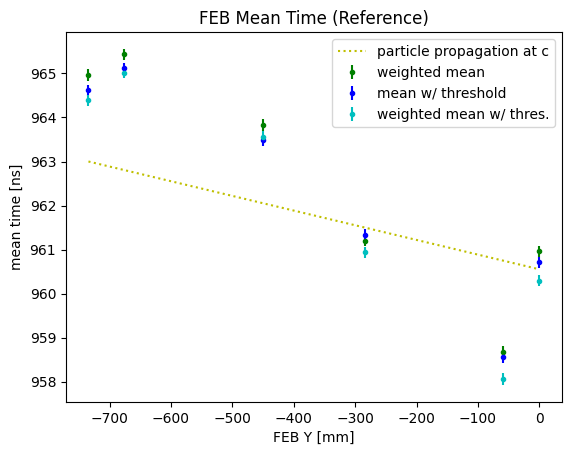

In [80]:
fig,ax = plt.subplots()
#plt.errorbar(FEB_Y, ref_mean_1, yerr=ref_mean_1_err, fmt='.', c='r', label='mean')
plt.errorbar(FEB_Y, ref_mean_2, yerr=ref_mean_2_err, fmt='.', c='g', label='weighted mean')
plt.errorbar(FEB_Y, ref_mean_3, yerr=ref_mean_3_err, fmt='.', c='b', label='mean w/ threshold')
plt.errorbar(FEB_Y, ref_mean_4, yerr=ref_mean_4_err, fmt='.', c='c', label='weighted mean w/ thres.')

# add stright line of -1ns/300mm
print('FEB mean Y position span =', max(FEB_Y)-min(FEB_Y))
xlist = [min(FEB_Y), max(FEB_Y)]
ylidt = [963., 963.-(max(FEB_Y)-min(FEB_Y))/300.]
plt.plot(xlist, ylidt, color='y', linestyle='dotted', label='particle propagation at c')

plt.title('FEB Mean Time (Reference)')
plt.xlabel('FEB Y [mm]')
plt.ylabel('mean time [ns]')
plt.legend()
plt.show()

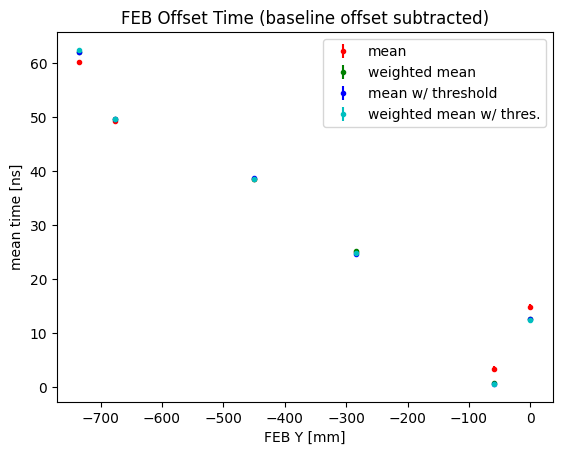

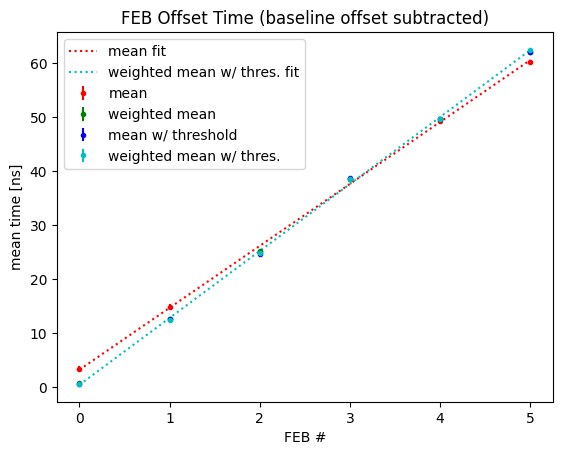

red : 11.479*x+3.172
cyan: 12.411*x+0.362
set offset = 12.56 ns


In [92]:
fig,ax = plt.subplots()
plt.errorbar(FEB_Y, offset_mean_1-ref_mean_1, yerr=np.sqrt(ref_mean_1_err**2+offset_mean_1_err**2), fmt='.', c='r', label='mean')
plt.errorbar(FEB_Y, offset_mean_2-ref_mean_2, yerr=np.sqrt(ref_mean_2_err**2+offset_mean_2_err**2), fmt='.', c='g', label='weighted mean')
plt.errorbar(FEB_Y, offset_mean_3-ref_mean_3, yerr=np.sqrt(ref_mean_3_err**2+offset_mean_3_err**2), fmt='.', c='b', label='mean w/ threshold')
plt.errorbar(FEB_Y, offset_mean_4-ref_mean_4, yerr=np.sqrt(ref_mean_4_err**2+offset_mean_4_err**2), fmt='.', c='c', label='weighted mean w/ thres.')
plt.title('FEB Offset Time (baseline offset subtracted)')
plt.xlabel('FEB Y [mm]')
plt.ylabel('mean time [ns]')
plt.legend()
plt.show()

def func(x,a,b):
    return a*x+b

FEBNum = np.array([i for i in range(6)])
fig,ax = plt.subplots()
plt.errorbar(FEBNum, offset_mean_1-ref_mean_1, yerr=np.sqrt(ref_mean_1_err**2+offset_mean_1_err**2), fmt='.', c='r', label='mean')
plt.errorbar(FEBNum, offset_mean_2-ref_mean_2, yerr=np.sqrt(ref_mean_2_err**2+offset_mean_2_err**2), fmt='.', c='g', label='weighted mean')
plt.errorbar(FEBNum, offset_mean_3-ref_mean_3, yerr=np.sqrt(ref_mean_3_err**2+offset_mean_3_err**2), fmt='.', c='b', label='mean w/ threshold')
plt.errorbar(FEBNum, offset_mean_4-ref_mean_4, yerr=np.sqrt(ref_mean_4_err**2+offset_mean_4_err**2), fmt='.', c='c', label='weighted mean w/ thres.')
plt.title('FEB Offset Time (baseline offset subtracted)')
plt.xlabel('FEB #')
plt.ylabel('mean time [ns]')
optimizedParameters1, pcov1 = opt.curve_fit(func, FEBNum, offset_mean_1-ref_mean_1)
plt.plot(FEBNum, func(FEBNum, *optimizedParameters1), c='r', label='mean fit',  linestyle='dotted')
optimizedParameters4, pcov4 = opt.curve_fit(func, FEBNum, offset_mean_4-ref_mean_4)
plt.plot(FEBNum, func(FEBNum, *optimizedParameters4), c='c', label='weighted mean w/ thres. fit',  linestyle='dotted')
plt.legend()
plt.show()

print ("red : %.3f*x+%.3f"%(optimizedParameters1[0],optimizedParameters1[1]))
print ("cyan: %.3f*x+%.3f"%(optimizedParameters4[0],optimizedParameters4[1]))
print ("set offset = 12.56 ns")

1. From the event display, we see with the current setup events > 300 PE per FEB is roughly 4%; the actual large showers that have potential to span multiple modules are more close to a rate of 2%. With ~200 events / 3min, a whole day of data taking would capture around 2k such events, which may not be sufficient for calibration. However, with the VST setup with no limitations from the scintillation paddle triggers, this may not be that large of a problem.
2. Very large shower events spanning multiple modules may not be that frequent and can take too long to calibrate the entire CRV-T together; another consideration is to calibration the timing of the modules in a pairwise manner and stitch things together afterwards. A tentative calibration scheme can be the following: with the 0-suppressed self-triggered data (within FEB), find coincidences within e.g. ~200ns, and perform the shower selection and time average comparison. 